# Создание признака кластера стран

Создадим признак кластера стран. Для его создания возьмем только признаки, которые есть с 2000 до 2020 гг.

In [3]:
import sys
# Добавим папку с корнем проекта в список системных директорий, чтобы Python видел путь к папкам utils и classes
sys.path.append('..')

In [4]:
import pandas as pd
import plotly.express as px

from utils.constants import (
    F, 
)
from utils.graphics import (
    display_corellation_by_target,
    display_silhouette,
    show_and_save_fig,
)
from utils.prepare_data import (
    get_train_test_data,
    get_scaled_data,
)
from classes.LocationCluster import LocationCluster

%matplotlib inline

from warnings import simplefilter
simplefilter('ignore')

In [5]:
# Загрузим таблицу
data_source = pd.read_csv(
    '../data/cumulative_life_expectancy_prepared.csv'
)

Логика формирования кластера вынесена в класс [LocationCluster](../classes/LocationCluster.py) \
Воспользуемся этим кодом.

In [6]:
# Удалим из данных признак кластера 
if (F.ClusterKMeans.value in data_source.columns):
    data = data_source.drop(columns=[F.ClusterKMeans.value])
else:
    data = data_source

# Разделим данные на тренировочные и тестовые
train_data, test_data = get_train_test_data(data)

Убедимся, что 2 - это по-прежнему оптимальное количество кластеров.

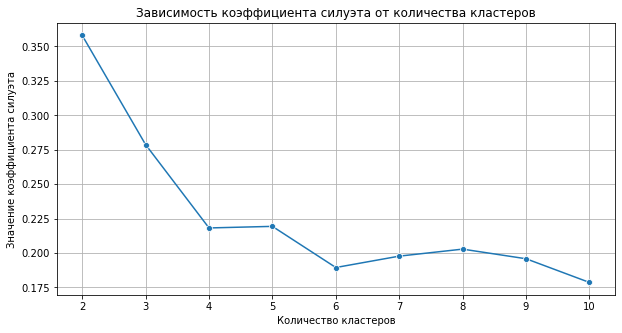

,silhouette,clusters_count
0,0.358095,2
1,0.278721,3
3,0.219333,5
2,0.218188,4
6,0.202804,8
5,0.197708,7
7,0.195806,9
4,0.189443,6
8,0.178597,10


In [7]:
# Масштабируем тренировочные данные
scaled_train_data = get_scaled_data(train_data)

# Построим график зависимости значения инерции от количества кластеров
display_silhouette(scaled_train_data, 2, 10)

Добавим признак кластера в тренировочные и тестовые данные.

In [8]:
# Создадим объект класса LocationCluster
cluster_creater = LocationCluster(2)
# Обучим его
cluster_creater.fit(train_data)

# Добавим кластер в тренировочные и тестовые данные
train_data = cluster_creater.transform(train_data)
test_data = cluster_creater.transform(test_data)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,1,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,1,50.06


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,LifeExpectancy
0,AFR,Africa,AGO,Angola,2018,25.83,0.00938,0.233096,24.0,0.013602,...,51.12,56.59,5.36,1.10,35.75,2538.591391,31297155.0,6.377063,1,62.27
1,AFR,Africa,AGO,Angola,2019,25.79,0.00920,0.227687,24.6,0.013479,...,51.39,56.88,5.51,1.12,29.33,2189.855714,32375632.0,6.488062,1,62.49


In [9]:
# Отобразим график с кластерами стран
fig = px.choropleth(
    train_data, 
    locations=F.SpatialDimValueCode.value, 
    color=F.ClusterKMeans.value,
    hover_name=F.Location.value,
    projection='natural earth',
    width=1000,
    height=700,
    title=f'Разделение стран на 2 кластера с помощью k-means',
)

show_and_save_fig(fig, 'feature_inginiring_kmeans_clusters')

Визуально разделение похоже на то, которое мы получили с учетом данных \
о причинах детской смертности [03_clustering.ipynb](../03_eda/03_clustering.ipynb)

Но есть различия. Например, Южная Африка здесь оказалась в кластере 0, а не в кластере 1, как раньше.

Посмотрим на корреляцию признака с целевым.

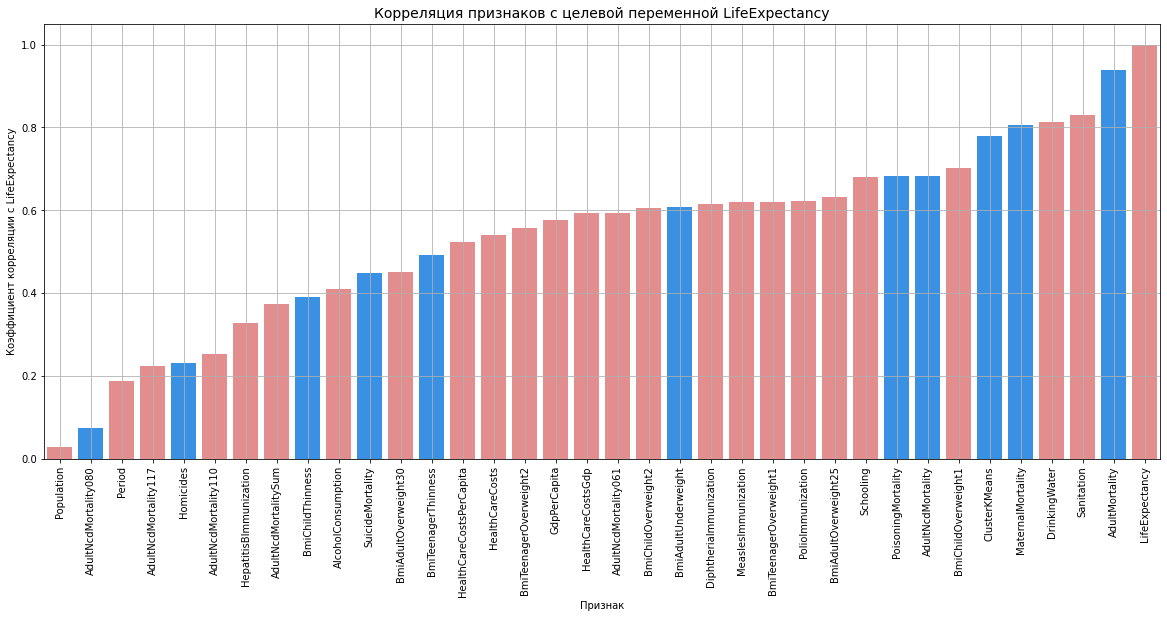

In [10]:
display_corellation_by_target(train_data, figsize=(20, 8))

Признак также имеет корреляцию с целевой переменной, близкую к 0.8. \
Но немного меньшую, чем предыдущий.

Будем добавлять признак непосредственно преде прогнозом в тренировочные и тестовые данные.\
А из основной таблицы уберем.

In [11]:
data.to_csv('../data/cumulative_life_expectancy_prepared.csv', index=False)